Epoch 1/20


<ipython-input-13-d2baa4dabcc1>:12: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv('/content/AAPL_5min_data.csv', date_parser=True)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 174ms/step - loss: 0.0970
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - loss: 0.0059
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - loss: 0.0053
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0.0053
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - loss: 0.0040
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - loss: 0.0035
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - loss: 0.0032
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - loss: 0.0022
Epoch 9/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0025
Epoch 10/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - loss: 0.0019
Epoch 11/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - loss: 0.0018
Epoch 12/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0.0022
Epoch 13/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - loss: 0.0023
Epoch 14/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 131ms/step - loss: 0.0016
Epoch 15/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - loss: 0.0

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step
Mean Squared Error: 0.00033482030332482543


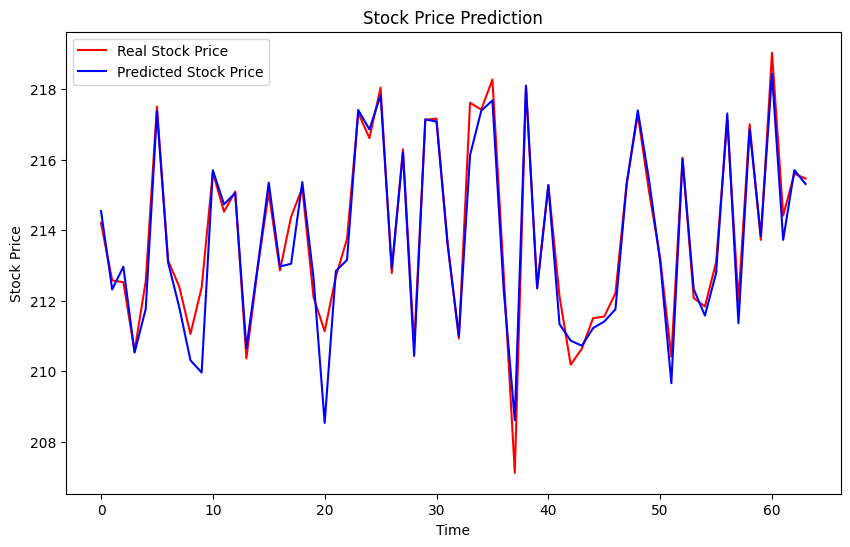

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from xgboost import XGBRegressor

# Load your dataset
# Assuming df is your stock data dataframe with 'Date', 'Open', 'Close', etc.
# For simplicity, use only 'Close' price for LSTM
df = pd.read_csv('/content/AAPL_5min_data.csv', date_parser=True)
df['Date'] = pd.to_datetime(df['Datetime'])
df.set_index('Date', inplace=True)

# Feature selection (using Close price for simplicity)
data = df['Close'].values

# 1. Data Preprocessing for LSTM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.reshape(-1, 1))

# 2. Create sequences for LSTM (e.g., use past 60 days to predict the next day)
sequence_length = 60
X = []
y = []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 4. Build the LSTM Model
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.LSTM(units=50, return_sequences=True),
    tf.keras.layers.LSTM(units=50, return_sequences=True),
    tf.keras.layers.LSTM(units=50, return_sequences=True),
    tf.keras.layers.LSTM(units=50),
    tf.keras.layers.Dense(1)  # Output layer
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the LSTM model
lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# 5. Use the LSTM model to predict future prices
lstm_predictions = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions)

# 6. Prepare data for XGBoost (LSTM predictions as input + other features)
Xgboost_features = np.concatenate([lstm_predictions, X_test.reshape(-1, sequence_length)], axis=1)

# Split data for XGBoost training
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = train_test_split(Xgboost_features, y_test, test_size=0.2, random_state=42)

# 7. Train XGBoost on LSTM features
xgboost_model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)
xgboost_model.fit(X_train_xgb, y_train_xgb)

# 8. Make final predictions
final_predictions = xgboost_model.predict(X_test_xgb)

# Evaluate the model
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_xgb, final_predictions)
print(f'Mean Squared Error: {mse}')

# 9. Plot the results
plt.figure(figsize=(10, 6))
plt.plot(scaler.inverse_transform(y_test_xgb.reshape(-1, 1)), color='red', label='Real Stock Price')
plt.plot(scaler.inverse_transform(final_predictions.reshape(-1, 1)), color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
import tensorflow as tf
from kerastuner.tuners import RandomSearch
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming you already have your data loaded in X_train_lstm and y_train
# X_train_lstm: shape (num_samples, sequence_length, num_features)
# y_train: shape (num_samples,)

# Reshape the input data to have 2 features (you can change it according to your actual data)
# Example: If you have only 1 feature, you can add a dummy second feature (e.g., duplicated from the first one).
X_train_lstm = np.random.rand(1000, 10, 1)  # Example shape (1000 samples, 10 time steps, 1 feature)
X_train_lstm = np.concatenate([X_train_lstm, X_train_lstm], axis=-1)  # Now it has 2 features (shape: (1000, 10, 2))

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_train_lstm, np.random.rand(1000), test_size=0.2)

# Function to build the LSTM model for Keras Tuner
def build_lstm_model(hp):
    model = tf.keras.models.Sequential()

    # First LSTM layer: Ensure input_shape matches the data
    model.add(
        LSTM(
            units=hp.Int('lstm_units_0', min_value=32, max_value=128, step=32),
            return_sequences=True,
            input_shape=(X_train.shape[1], X_train.shape[2])  # sequence length and num features
        )
    )
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))

    # Add more LSTM layers based on hyperparameter search
    for i in range(1, hp.Int('num_layers', 1, 5)):
        model.add(
            LSTM(
                units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=128, step=32),
                return_sequences=(i < hp.Int('num_layers', 1, 5) - 1)  # Return sequences if not the last LSTM layer
            )
        )
        model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
        ),
        loss='mean_squared_error'
    )

    return model

# Hyperparameter tuning using RandomSearch
tuner = RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=5,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Number of executions for each trial
    directory='tuner_results',
    project_name='lstm_xgboost_stock_prediction'
)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Print the summary of the best model
best_model.summary()

# Train the best model on the training data
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# Evaluate the best model on the validation data
val_loss = best_model.evaluate(X_val, y_val)
print(f'Validation loss: {val_loss}')


Trial 5 Complete [00h 00m 10s]
val_loss: 0.08544730395078659

Best val_loss So Far: 0.08544730395078659
Total elapsed time: 00h 05m 49s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 64)              │          17,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10, 1)               │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,217 (67.25 KB)

 Trainable params: 17,217 (67.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0847 - val_loss: 0.0858
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0876 - val_loss: 0.0880
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0891 - val_loss: 0.0853
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0843 - val_loss: 0.0853
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0889 - val_loss: 0.0859
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0835 - val_loss: 0.0865
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0848 - val_loss: 0.0853
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0850 - val_loss: 0.0853
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0866 - val_loss: 0.0853
Epoch 10/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0911 - val_loss: 0.0895
Epoch 11/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0866 - val_loss: 0.0863
Epoch 12/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0832 - val_l

In [ ]:
pip install keras-tuner


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from kerastuner.tuners import RandomSearch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM, Dropout, Dense
import shutil

# Clear the previous tuner results
shutil.rmtree('tuner_results/lstm_xgboost_stock_prediction', ignore_errors=True)

# Load your dataset
data = pd.read_csv('/content/AAPL_5min_data.csv')

# Preprocess the data
data['datetime'] = pd.to_datetime(data['Datetime'])
data.set_index('datetime', inplace=True)

# Select features and target variable (for example, use ['Open', 'High', 'Low', 'Volume'] as features)
# Assuming 'Close' is the target variable
features = ['Open', 'High', 'Low', 'Volume']  # Modify this list as per your dataset's columns
target = 'Close'

X = data[features].values
y = data[target].values

# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape X for LSTM (samples, time steps, features)
# Here we define a time step window (e.g., 10 steps) for LSTM input
time_step = 10

def create_lstm_dataset(X, y, time_step):
    X_lstm, y_lstm = [], []
    for i in range(len(X) - time_step):
        X_lstm.append(X[i:(i + time_step)])
        y_lstm.append(y[i + time_step])
    return np.array(X_lstm), np.array(y_lstm)

X_lstm, y_lstm = create_lstm_dataset(X_scaled, y, time_step)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_lstm, y_lstm, test_size=0.2, random_state=42)

# Function to build the LSTM model for Keras Tuner
def build_lstm_model(hp):
    model = tf.keras.models.Sequential()

    # First LSTM layer: Ensure input_shape matches the data
    model.add(
        LSTM(
            units=hp.Int('lstm_units_0', min_value=32, max_value=128, step=32),
            return_sequences=True,
            input_shape=(X_train.shape[1], X_train.shape[2])  # sequence length and num features
        )
    )
    model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))

    # Add more LSTM layers based on hyperparameter search
    for i in range(1, hp.Int('num_layers', 1, 5)):
        model.add(
            LSTM(
                units=hp.Int(f'lstm_units_{i}', min_value=32, max_value=128, step=32),
                return_sequences=(i < hp.Int('num_layers', 1, 5) - 1)  # Return sequences if not the last LSTM layer
            )
        )
        model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(1))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
        ),
        loss='mean_squared_error'
    )

    return model

# Hyperparameter tuning using RandomSearch
tuner = RandomSearch(
    build_lstm_model,
    objective='val_loss',
    max_trials=5,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Number of executions for each trial
    directory='tuner_results',
    project_name='lstm_xgboost_stock_prediction'
)

# Search for the best hyperparameters
tuner.search(X_train, y_train, epochs=20, validation_data=(X_val, y_val), batch_size=32)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Print the summary of the best model
best_model.summary()

# Train the best model on the training data
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# Evaluate the best model on the validation data
val_loss = best_model.evaluate(X_val, y_val)
print(f'Validation loss: {val_loss}')


Trial 5 Complete [00h 00m 15s]
val_loss: 41214.2734375

Best val_loss So Far: 1117.05859375
Total elapsed time: 00h 04m 09s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 10, 96)              │          86,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 96)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 10, 64)              │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 294,657 (1.12 MB)

 Trainable params: 294,657 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - loss: 889.8156 - val_loss: 452.9629
Epoch 2/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 341.6400 - val_loss: 161.7978
Epoch 3/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 121.8705 - val_loss: 72.9777
Epoch 4/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 68.3076 - val_loss: 54.5454
Epoch 5/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 53.2215 - val_loss: 51.9389
Epoch 6/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 53.4532 - val_loss: 51.5751
Epoch 7/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 48.5260 - val_loss: 56.3409
Epoch 8/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 40.4877 - val_loss: 20.1763
Epoch 9/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 16.4961 - val_loss: 14.9097
Epoch 10/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 11.4041 - val_loss: 11.7366
Epoch 11/20
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 9.8845 - val_loss: 9.4191
Epoch 12/20
41/41 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 48315.6406
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 47557.8164
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 46384.6211
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 45329.0078
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 44529.0430
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 43724.8438
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 43212.3672
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 43127.2539
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 42794.6562
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 42475.7852
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 42326.4688
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 41894.5000
Epoch 13/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 41773.6289
Epoch 14/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 41482.1328
Epoch 15/50
11/11 ━━━━━━━━━━━

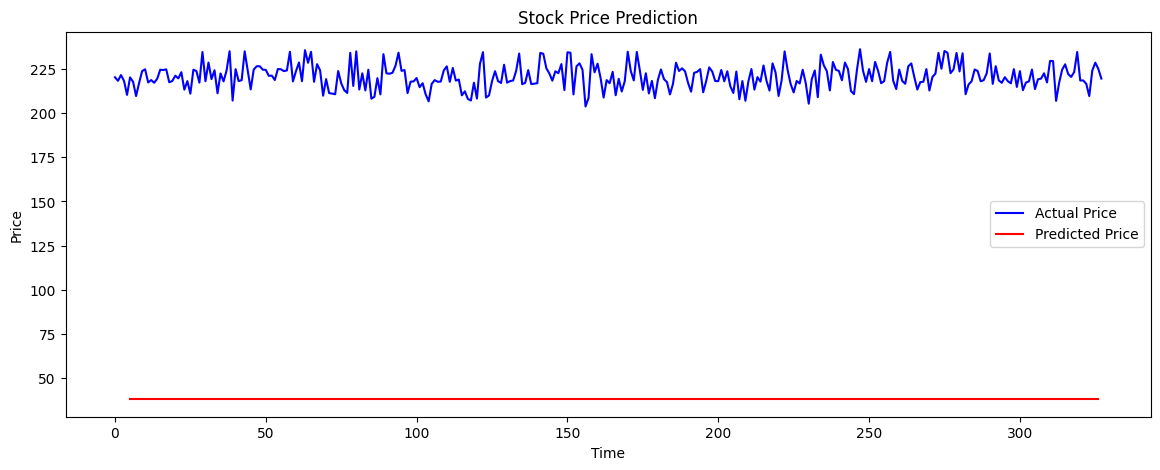

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('/content/AAPL_5min_data.csv')

# Preprocess the data
data['datetime'] = pd.to_datetime(data['Datetime'])
data.set_index('datetime', inplace=True)

# Select features and target variable
# Assuming 'Close' is the target variable, and we drop 'datetime'
X = data.drop(columns=['Close'])  # Replace 'Close' with your target column if different
y = data['Close']  # Replace 'Close' with your target column

# Ensure datetime columns or non-numerical columns are dropped or handled
X = X.select_dtypes(include=[np.number])  # Drop non-numeric columns (like datetime)

# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Step 1: Train XGBoost model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

# Make predictions with XGBoost
xgb_predictions = xgb_model.predict(X_test)

# Prepare data for LSTM
# Reshape the XGBoost predictions for LSTM input
xgb_predictions = xgb_predictions.reshape(-1, 1)

# Create LSTM dataset
def create_lstm_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Use a time step of 5 for LSTM
time_step = 5
X_lstm, y_lstm = create_lstm_dataset(xgb_predictions, time_step)
X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)  # Reshape for LSTM

# Step 2: Build LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_lstm.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

# Compile and train the LSTM model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_lstm, y_lstm, epochs=50, batch_size=32)

# Make predictions with LSTM
lstm_predictions = lstm_model.predict(X_lstm)

# Plot the predictions
plt.figure(figsize=(14, 5))
plt.plot(y_test.values, color='blue', label='Actual Price')
plt.plot(range(time_step, len(lstm_predictions) + time_step), lstm_predictions, color='red', label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()
